### TODOS: Wrap in Function, HPO, Class imbalance

In [25]:
import numpy as np
import pandas as pd 
import h5py

In [81]:
#Modelling libraries
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

#from sklearn.feature_selection import VarianceThreshold <- use to remove low variance features

from bayes_opt import BayesianOptimization #!pip install bayesian-optimization

In [51]:
file_path = r"C:\Users\likai\Desktop\My Life\Master\3. Semester\Innolabs\Test"

In [52]:
features = pd.read_csv(file_path + '\X_train.csv')
labels = pd.read_csv(file_path + '\y_train.csv')

In [54]:
features.head(2)

,ConnID,Repseudonym,siteid,age,visdat,sex,edyears,MEM_score,Apoe,IDs,...,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
0,713,dd893aeed,11,73,27.04.2016,0,13,-0.013670,0.0,713.0,...,0.283663,0.429915,0.094293,0.502726,0.435048,0.160833,0.491221,0.344239,0.500945,0.539911
1,223,23cd008c9,17,66,14.01.2016,0,13,-0.904723,0.0,223.0,...,0.990928,0.670364,0.028671,0.369321,0.724319,0.113276,0.254525,0.114425,0.139861,0.442906


In [73]:
#features.describe()
round(features.describe(), 2)

,age,sex,edyears,MEM_score,Apoe,1_2,1_3,1_4,1_5,1_6,...,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
count,589.00,589.00,589.00,589.00,579.00,589.00,589.00,589.00,589.00,589.00,...,589.00,589.00,589.00,589.00,589.00,589.00,589.00,589.00,589.00,589.00
mean,71.25,0.49,14.59,0.21,0.31,0.71,0.37,0.15,0.28,0.13,...,0.51,0.40,0.04,0.13,0.56,0.07,0.16,0.05,0.09,0.50
std,5.94,0.50,2.95,0.76,0.46,0.28,0.26,0.29,0.26,0.27,...,0.22,0.20,0.18,0.20,0.24,0.19,0.21,0.17,0.18,0.23
min,59.00,0.00,8.00,-2.43,0.00,-0.02,-0.44,-0.92,-0.39,-0.63,...,-0.04,-0.25,-0.54,-0.40,-0.09,-0.70,-0.40,-0.58,-0.48,-0.07
25%,66.00,0.00,12.00,-0.24,0.00,0.53,0.21,-0.04,0.13,-0.03,...,0.35,0.27,-0.08,-0.01,0.39,-0.06,0.03,-0.06,-0.03,0.34
50%,71.00,0.00,14.00,0.33,0.00,0.70,0.36,0.13,0.28,0.15,...,0.50,0.40,0.04,0.11,0.55,0.08,0.16,0.05,0.09,0.48
75%,76.00,1.00,17.00,0.77,1.00,0.88,0.50,0.31,0.46,0.30,...,0.65,0.53,0.16,0.26,0.70,0.19,0.29,0.16,0.20,0.67
max,87.00,1.00,20.00,1.74,1.00,1.71,1.46,1.27,1.24,1.11,...,1.34,1.36,0.67,0.78,1.32,0.70,0.80,0.58,0.97,1.34


In [55]:
features.drop(['ConnID','Repseudonym','visdat','siteid','IDs'], axis = 1, inplace = True)

In [104]:
n_features = features.shape[1]

### Slight Class imbalance

In [56]:
labels.value_counts()

target
1         415
0         174
dtype: int64

#### Train Test Split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 42, stratify = labels)

#### impute missing values

In [60]:
features[features.isna().any(axis=1)]

,age,sex,edyears,MEM_score,Apoe,1_2,1_3,1_4,1_5,1_6,...,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
5,71,1,12,0.532176,NaN,0.825025,0.401671,-0.059197,0.590409,0.191141,...,0.657187,0.559150,0.139845,0.077936,0.760968,0.139346,0.231843,0.095432,0.022125,0.355813
31,79,1,13,0.719214,NaN,0.797040,0.370490,0.059678,0.218447,-0.122462,...,0.363497,0.231037,0.252773,0.431979,0.552066,0.013893,0.161084,-0.142823,-0.075208,0.666441
53,66,1,16,0.636514,NaN,0.599700,0.172902,-0.143808,0.145856,0.150976,...,0.254868,0.230583,-0.153607,-0.086144,0.356617,0.076132,0.228457,-0.031727,-0.084820,0.349648
142,75,0,18,0.762609,NaN,0.680516,0.195269,0.051028,-0.181582,-0.370377,...,0.429578,0.202003,-0.048061,0.085829,0.493708,-0.175098,0.020038,0.094296,0.091947,0.666868
182,65,1,13,0.633007,NaN,0.180014,0.477626,0.143820,-0.054953,0.315783,...,0.222863,0.351755,-0.137550,0.203394,0.164663,0.234830,0.283645,-0.168066,-0.053491,0.241715
212,69,1,13,0.708661,NaN,0.565332,0.332528,-0.015577,0.527998,0.265987,...,0.575368,0.379398,0.153072,0.188878,0.463371,0.099339,0.027374,0.127089,0.073215,0.146653
364,76,0,18,0.606709,NaN,0.996305,0.367788,0.100133,0.155016,0.210940,...,0.595886,0.631427,-0.428729,-0.214912,0.508756,-0.030101,-0.036561,-0.222306,-0.279244,0.717552
371,73,0,15,0.960465,NaN,0.096872,0.557218,0.214068,0.509772,0.182487,...,0.163846,0.341396,-0.147789,0.000514,0.771436,0.070868,0.063309,-0.067410,-0.118623,0.228284
469,69,0,19,0.771720,NaN,0.847197,0.493921,0.246722,0.064244,-0.120988,...,0.443439,0.453103,0.061905,0.130288,0.258236,0.103495,0.249588,0.119246,0.310112,0.520474
490,68,1,13,-0.009455,NaN,0.454760,0.352159,0.356721,0.168407,-0.065728,...,0.287323,0.355061,0.124930,0.126580,0.671913,0.112314,0.212601,0.161997,0.228620,0.774473


In [61]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

#### Scale Data

In [62]:
scaler = StandardScaler()

In [63]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [110]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 200, random_state = 42)
#rf = RandomForestClassifier(n_estimators = 200, random_state = 42, max_depth = 10, max_features= int(n_features//6))
rf.fit(X_train, np.ravel(y_train))

RandomForestClassifier(max_depth=10, max_features=5023, n_estimators=200,
                       random_state=42)

### Evaluation

In [111]:
predictions = rf.predict(X_test)

In [112]:
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)
auc = roc_auc_score(y_test,predictions)

In [113]:
pd.DataFrame({"Accuracy":[accuracy], "Precision":[precision], "Recall": [recall], "F1":[f1], "AUC":[auc]})

,Accuracy,Precision,Recall,F1,AUC
0,0.689189,0.69863,0.980769,0.816,0.490385


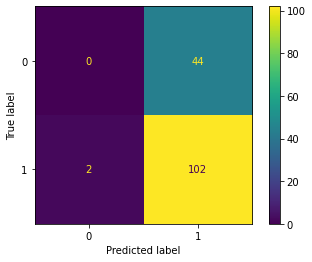

In [114]:
plot_confusion_matrix(rf, X_test, y_test)  

In [75]:
importances = list(rf.feature_importances_)

In [96]:
feature_list = list(features.columns)

feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:10]]

Variable: 65_68                Importance: 0.0015025258
Variable: 12_179               Importance: 0.0014523069
Variable: 163_199              Importance: 0.0011391896
Variable: 97_199               Importance: 0.0010921327
Variable: 58_161               Importance: 0.0010568012
Variable: 135_200              Importance: 0.0010422176
Variable: 179_201              Importance: 0.0010283619
Variable: MEM_score            Importance: 0.0010254857
Variable: 144_244              Importance: 0.0010222525
Variable: 9_161                Importance: 0.0010116668


[None, None, None, None, None, None, None, None, None, None]